# Load the data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/OPG REPORTING.v8-opg-reduced-classes.coco-segmentation_rabia_v2.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -o "{zip_path}" -d "./extracted_opg" /dev/null 2>&1

Archive:  /content/drive/MyDrive/OPG REPORTING.v8-opg-reduced-classes.coco-segmentation_rabia_v2.zip
caution: filename not matched:  /dev/null


# View the dataset

In [ ]:
!pip install -q pycocotools

In [ ]:
!pip install -q opencv-python

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import json
import numpy as np
import random
import copy
import shutil
from google.colab import files
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

import cv2

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


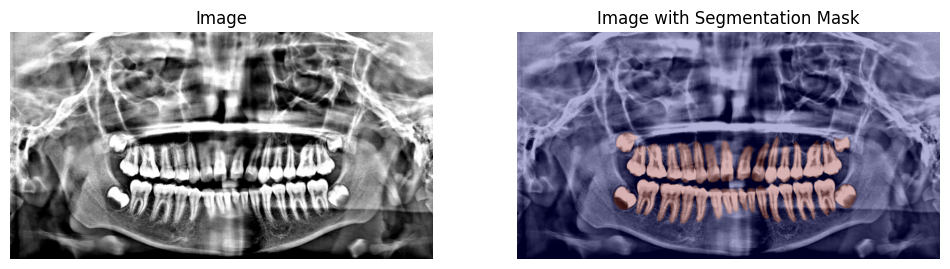

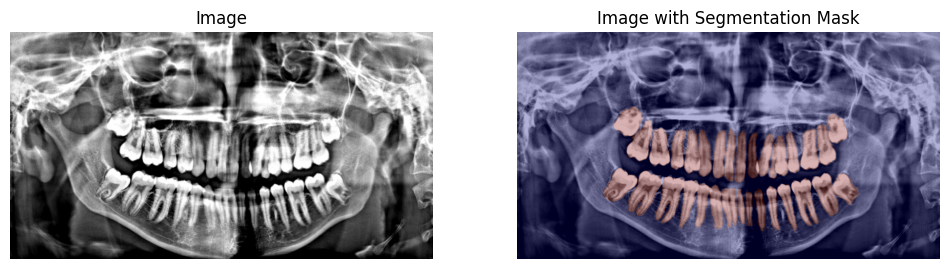

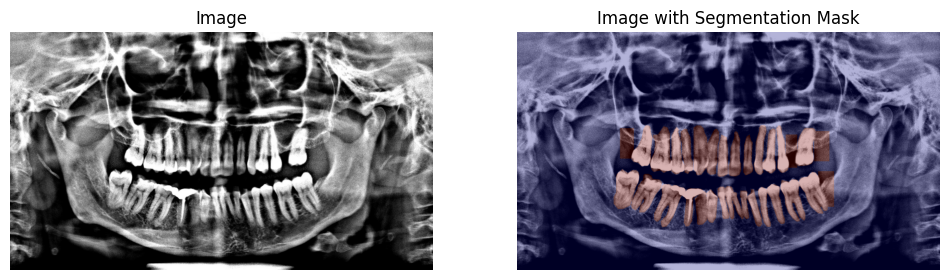

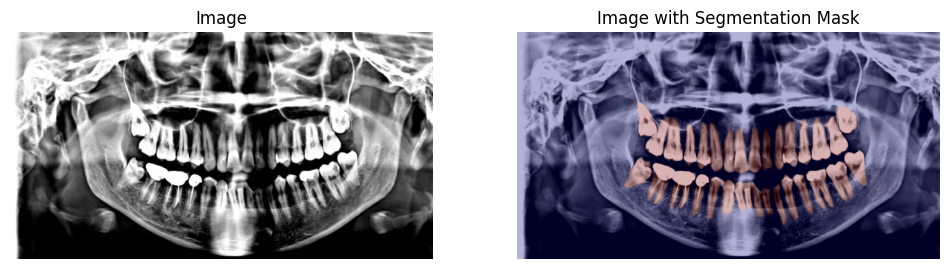

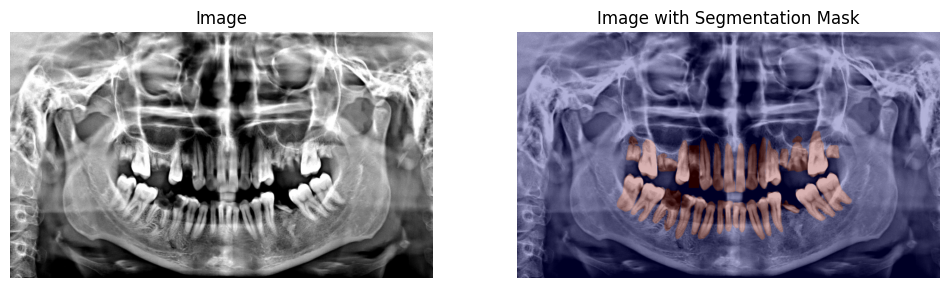

In [ ]:
annotation_path = '/content/extracted_opg/train/_annotations.coco.json'
images_path = '/content/extracted_opg/train/'

coco = COCO(annotation_path)
image_ids = coco.getImgIds()
sample_ids = random.sample(image_ids, 5)

for image_id in sample_ids:
    # Load image metadata and the actual image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(images_path, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    # Create a mask for the annotations
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in annotations:
        if 'segmentation' in ann:
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                poly = poly.astype(np.int32)
                cv2.fillPoly(mask, [poly], color=255)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis('off')

    ax[1].imshow(image)
    ax[1].imshow(mask, alpha=0.3, cmap='jet')
    ax[1].set_title("Image with Segmentation Mask")
    ax[1].axis('off')

    plt.show()

In [ ]:
categories = coco.loadCats(coco.getCatIds())

print("Available categories in the COCO annotation file:")
for category in categories:
    print(f"  - ID: {category['id']}, Name: {category['name']}")

image_ids = coco.getImgIds()

if not image_ids:
    print("No images found in the annotation file. Exiting...")
    exit()

image_info = coco.loadImgs(image_ids[0])[0]
print("\nExample image information:")
print(json.dumps(image_info, indent=2))

annotation_ids = coco.getAnnIds(imgIds=image_ids[0])
annotations = coco.loadAnns(annotation_ids)
print("\nExample annotation information:")
print(json.dumps(annotations, indent=2))

Available categories in the COCO annotation file:
  - ID: 0, Name: OPG-data
  - ID: 1, Name: 11
  - ID: 2, Name: 12
  - ID: 3, Name: 13
  - ID: 4, Name: 14
  - ID: 5, Name: 15
  - ID: 6, Name: 16
  - ID: 7, Name: 17
  - ID: 8, Name: 18
  - ID: 9, Name: 21
  - ID: 10, Name: 22
  - ID: 11, Name: 23
  - ID: 12, Name: 24
  - ID: 13, Name: 25
  - ID: 14, Name: 26
  - ID: 15, Name: 27
  - ID: 16, Name: 28
  - ID: 17, Name: 31
  - ID: 18, Name: 32
  - ID: 19, Name: 33
  - ID: 20, Name: 34
  - ID: 21, Name: 35
  - ID: 22, Name: 36
  - ID: 23, Name: 37
  - ID: 24, Name: 38
  - ID: 25, Name: 41
  - ID: 26, Name: 42
  - ID: 27, Name: 43
  - ID: 28, Name: 44
  - ID: 29, Name: 45
  - ID: 30, Name: 46
  - ID: 31, Name: 47
  - ID: 32, Name: 48
  - ID: 33, Name: RC-treated
  - ID: 34, Name: RC-treated-and-root-stump
  - ID: 35, Name: RPD clasp
  - ID: 36, Name: bridge
  - ID: 37, Name: calculus
  - ID: 38, Name: cantilever
  - ID: 39, Name: caries
  - ID: 40, Name: cast partial denture
  - ID: 41, Nam

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import torchvision.models as models
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

class OPGDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.transform = transform
        self.categories = {cat['id']: cat['name'] for cat in self.data['categories']}

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        img_info = self.data['images'][idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        ann = next(ann for ann in self.data['annotations'] if ann['image_id'] == img_info['id'])
        label = ann['category_id'] - 1  # Subtract 1 to make labels 0-indexed

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = OPGDataset('/content/extracted_opg/train/_annotations.coco.json', '/content/extracted_opg/train', transform)
val_dataset = OPGDataset('/content/extracted_opg/valid/_annotations.coco.json', '/content/extracted_opg/valid', transform)
test_dataset = OPGDataset('/content/extracted_opg/test/_annotations.coco.json', '/content/extracted_opg/test', transform)

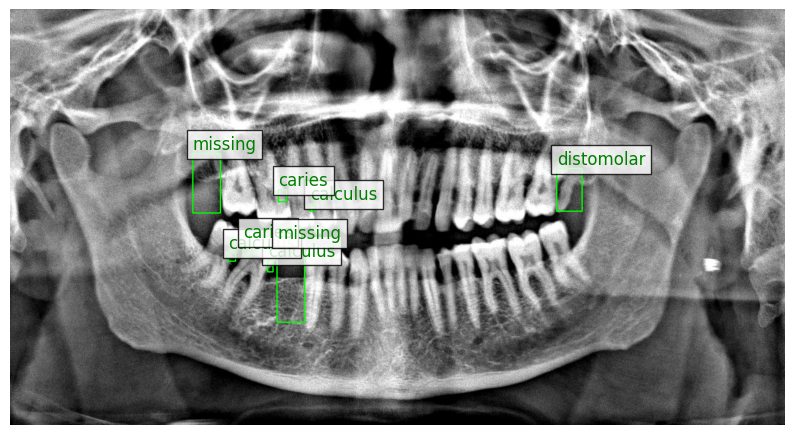

In [ ]:
image_ids = coco.getImgIds()
image_id = random.choice(image_ids)

# Load image metadata and the actual image
img_info = coco.loadImgs(image_id)[0]
img_path = os.path.join(images_path, img_info['file_name'])
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')

for ann in annotations:
    category_id = ann['category_id']
    if 33 <= category_id <= 62:
        bbox = ann['bbox']
        x, y, w, h = bbox
        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)

        category_info = coco.loadCats(category_id)[0]
        category_name = category_info['name']
        plt.text(int(x), int(y) - 10, category_name, color='green',
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.imshow(image)
plt.show()

Multi label checking

In [ ]:
def analyze_multilabel_images(json_path):
    """
    Analyzes COCO-format annotations to identify multi-label images.

    Args:
        json_path (str): Path to the COCO-format JSON annotation file.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Map image_id -> set of category_ids
    image_to_categories = defaultdict(set)
    for ann in data['annotations']:
      if 33 <= ann['category_id'] <= 62:
            image_to_categories[ann['image_id']].add(ann['category_id'])

    label_counts = [len(cats) for cats in image_to_categories.values()]
    count_distribution = Counter(label_counts)

    print(f"\n[INFO] Analyzing: {os.path.basename(json_path)}")
    print("Distribution of category counts per image:")
    for num_labels, count in sorted(count_distribution.items()):
        print(f"  {num_labels} label(s): {count} image(s)")

    print("\nMulti-label image details:")
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    id_to_categories = {cat['id']: cat['name'] for cat in data['categories']}

    multi_label_image_ids = [img_id for img_id, cats in image_to_categories.items() if len(cats) > 1]
    if not multi_label_image_ids:
        print("  No multi-label images found.")
    else:
        for img_id in multi_label_image_ids:
            cat_names = [id_to_categories[cat_id] for cat_id in image_to_categories[img_id]]
            print(f"  Image: {id_to_filename[img_id]} | Categories: {cat_names}")

    # Plot distribution
    plt.figure(figsize=(8, 4))
    plt.bar(count_distribution.keys(), count_distribution.values(), color='skyblue')
    for num_labels, count in count_distribution.items():
        plt.text(x=num_labels,
                 y=count + (0.01 * max(count_distribution.values())),
                 s=str(count),
                 ha='center')
    plt.xlabel("Number of categories per image")
    plt.ylabel("Number of images")
    plt.title(f"Multi-label distribution for {os.path.basename(json_path)}")
    plt.xticks(range(1, max(count_distribution.keys()) + 1))
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_multilabel_images(json_path, img_dir):
    """
    Displays a maximum of 5 images with more than one label

    Args:
        json_path (str): Path to the annotation JSON file.
        img_dir (str): Path to the image directory.
    """
    coco = COCO(json_path)

    id_to_filename = {img['id']: img['file_name'] for img in coco.dataset['images']}
    id_to_categories = {cat['id']: cat['name'] for cat in coco.dataset['categories']}

    image_annotations = defaultdict(list)
    for ann in coco.dataset['annotations']:
        if 33 <= ann['category_id'] <= 62:
            image_annotations[ann['image_id']].append(ann)

    multi_label_image_ids = []
    for image_id, anns in image_annotations.items():
        category_ids = {ann['category_id'] for ann in anns}
        if len(category_ids) > 1:
            multi_label_image_ids.append(image_id)

    print(f"Found {len(multi_label_image_ids)} multi-label images. Displaying up to 5.")

    for image_id in multi_label_image_ids[:5]:
        anns = image_annotations[image_id]
        category_ids_for_title = {ann['category_id'] for ann in anns}

        filename = id_to_filename[image_id]
        img_path = os.path.join(img_dir, filename)
        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            continue

        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        plt.figure(figsize=(15, 10))
        plt.imshow(image)

        for ann in anns:
            bbox = ann['bbox']
            category_id = ann['category_id']
            x, y, w, h = bbox

            draw.rectangle([x, y, x + w, y + h], outline='red', width=3)

            category_info = coco.loadCats(category_id)[0]
            category_name = category_info['name']
            plt.text(int(x), int(y) - 10, category_name, color='green',
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

        plt.title(f"{filename} - Categories: {[id_to_categories[cid] for cid in category_ids_for_title]}")
        plt.axis('off')
        plt.show()

In [ ]:
# analyze_multilabel_images('/content/extracted_opg/train/_annotations.coco.json')

In [ ]:
# analyze_multilabel_images('/content/extracted_opg/valid/_annotations.coco.json')

In [ ]:
# analyze_multilabel_images('/content/extracted_opg/test/_annotations.coco.json')

In [ ]:
# visualize_multilabel_images('/content/extracted_opg/train/_annotations.coco.json', '/content/extracted_opg/train')

Find rare and unused classes.

In [ ]:
def plot_specific_category_distribution(base_dir, set_name):
    """
    Analyzes a COCO annotation file to plot the distribution of specific categories.

    This function is designed for the path structure:
    '{base_dir}/{set_name}/_annotations.coco.json'

    It counts instances for category IDs between 33 and 62 (inclusive) and
    generates a bar chart visualizing the distribution with counts on top of each bar.

    Args:
        base_dir (str): The base directory containing the set-specific folders
                        (e.g., '/content/extracted_opg').
        set_name (str): The name of the dataset split (e.g., 'train', 'test', 'valid').
    """
    json_path = os.path.join(base_dir, set_name, '_annotations.coco.json')

    if not os.path.exists(json_path):
        print(f"Error: Annotation file not found at '{json_path}'")
        return

    print(f"[INFO] Loading annotations from: {json_path}")
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Count occurrences of each category in the specified range
    category_counts = defaultdict(int)
    for ann in data['annotations']:
        if 33 <= ann['category_id'] <= 62:
            category_counts[ann['category_id']] += 1

    if not category_counts:
        print(f"No categories found in the range 33-62 for the '{set_name}' set.")
        return

    id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

    # Sort categories by count in descending order
    sorted_counts = sorted(category_counts.items(), key=lambda item: item[1], reverse=True)

    category_names = [id_to_name.get(item[0], f"ID:{item[0]}") for item in sorted_counts]
    counts = [item[1] for item in sorted_counts]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 9)) # Use a 16:9 aspect ratio

    colors = plt.cm.viridis(np.linspace(0.4, 0.9, len(counts)))
    bars = ax.bar(category_names, counts, color=colors, edgecolor='black', zorder=2)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{height}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_xlabel("Category Name", fontsize=14, fontweight='bold')
    ax.set_ylabel("Number of Instances", fontsize=14, fontweight='bold')
    ax.set_title(f"Category Distribution for '{set_name}' Set (IDs 33-62)", fontsize=18, fontweight='bold')
    plt.xticks(rotation=45, ha="right", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

    ax.set_ylim(0, max(counts) * 1.15)

    plt.tight_layout()

[INFO] Loading annotations from: /content/extracted_opg/train/_annotations.coco.json
[INFO] Loading annotations from: /content/extracted_opg/valid/_annotations.coco.json
[INFO] Loading annotations from: /content/extracted_opg/test/_annotations.coco.json


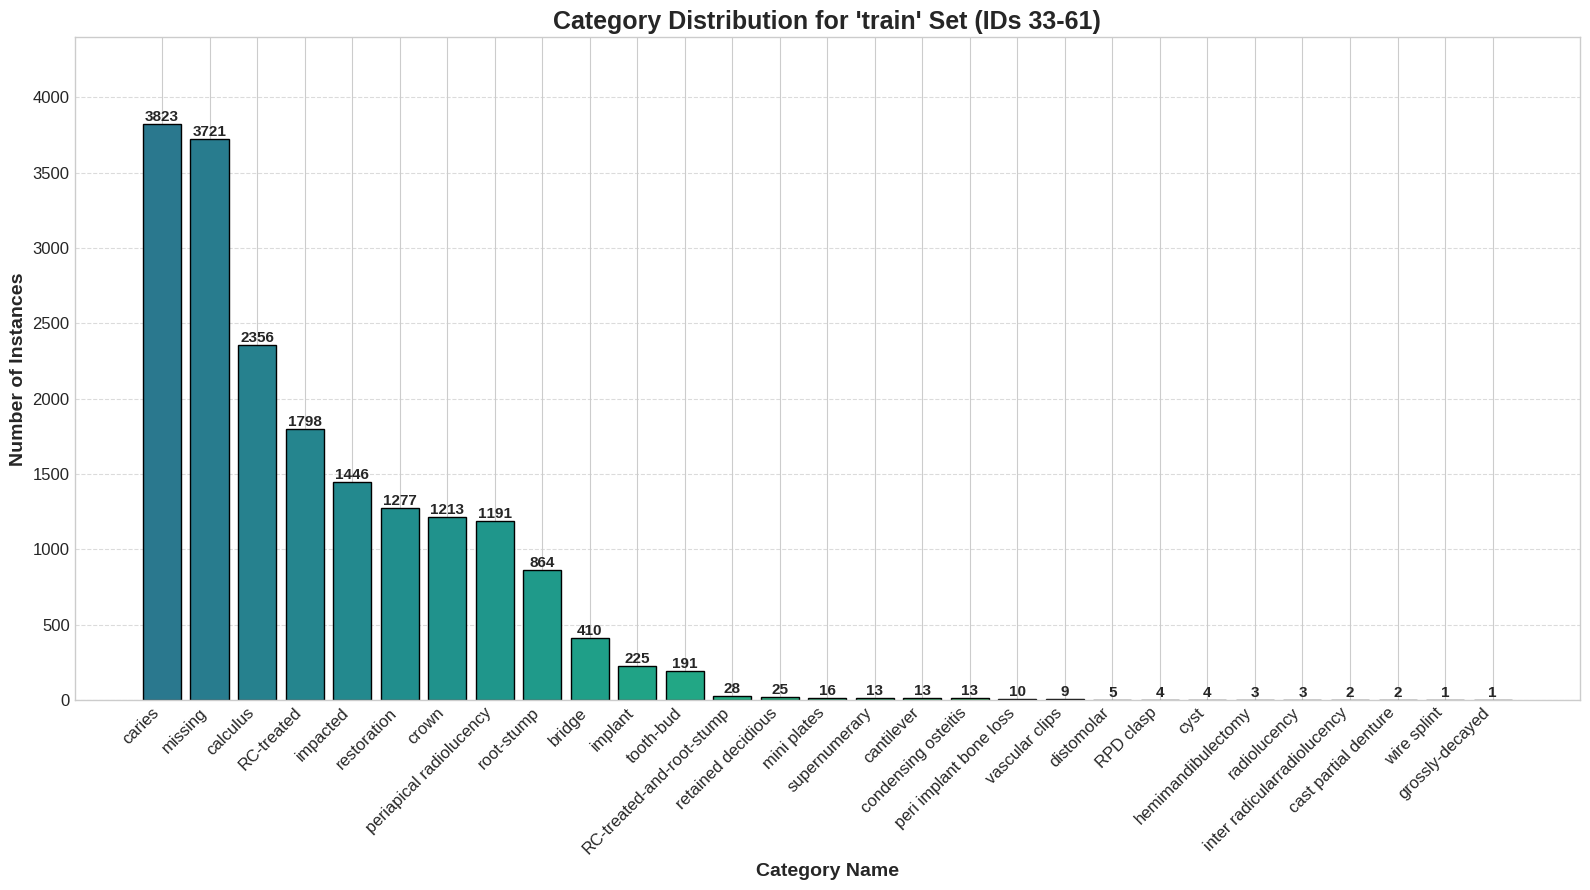

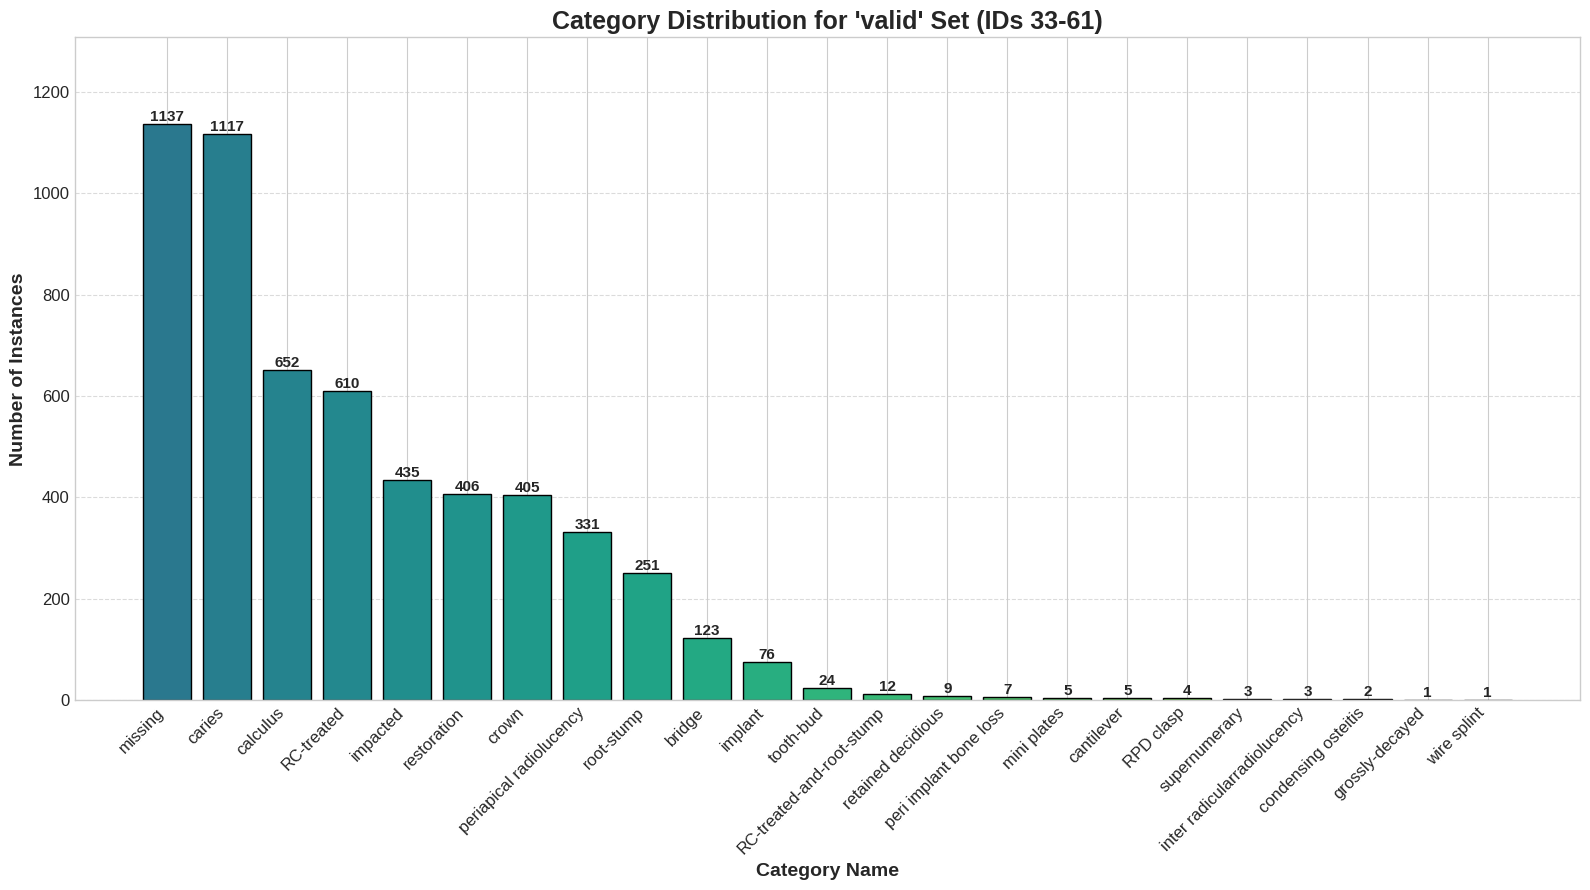

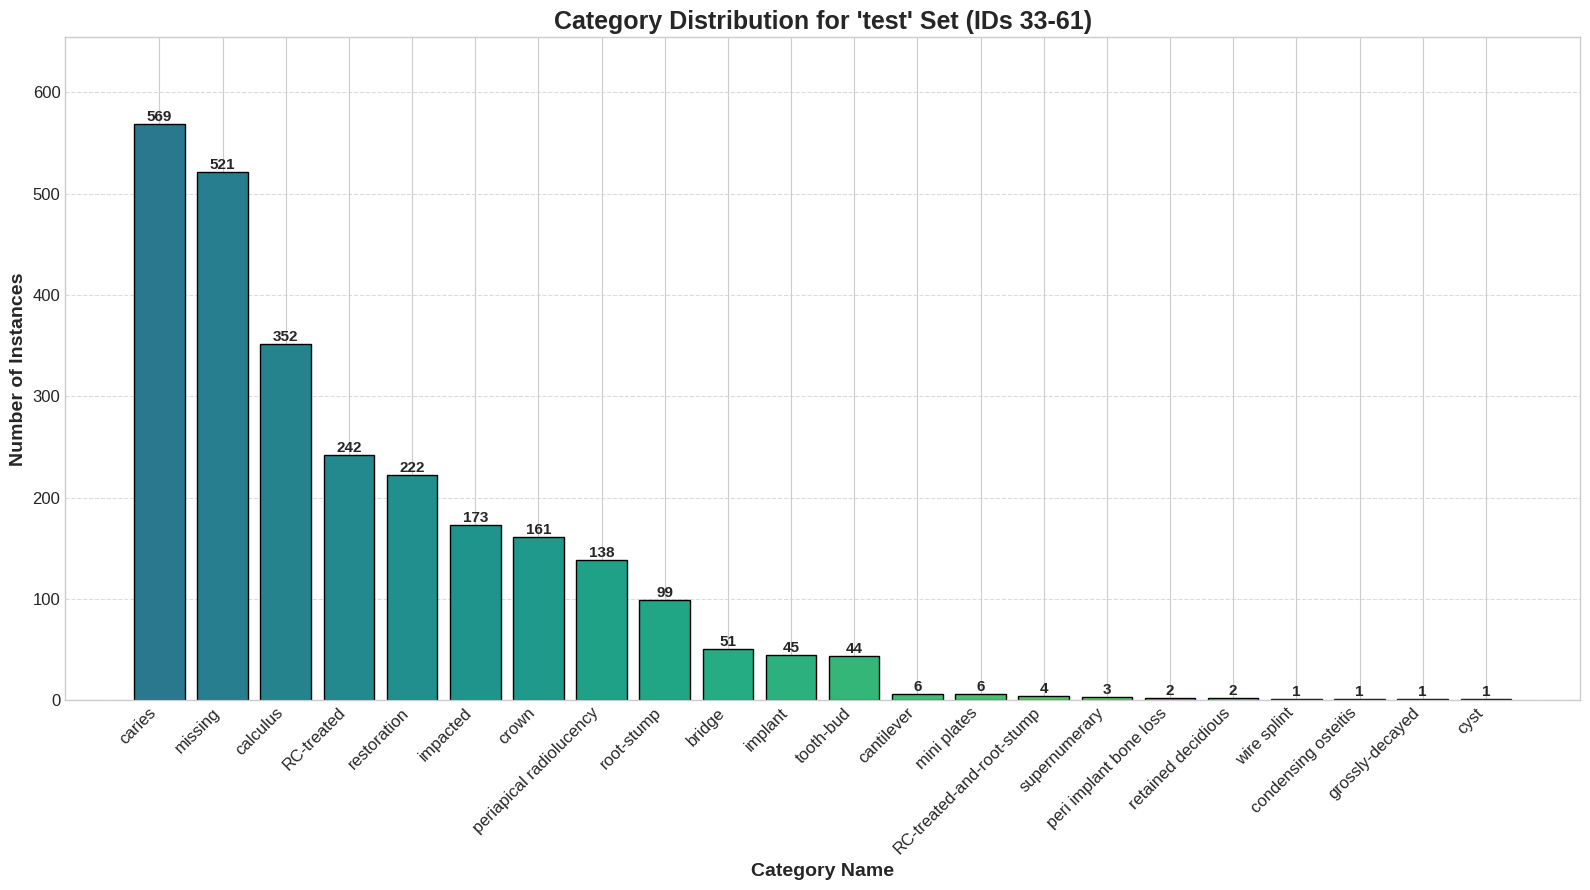

In [ ]:
BASE_DATA_DIRECTORY = '/content/extracted_opg'
for split in ['train', 'valid', 'test']:
        plot_specific_category_distribution(BASE_DATA_DIRECTORY, split)

- Preserve

caries, missing, calculus, RC-treated, impacted, restoration, crown, periapical radiolucency, root-stump, bridge, implant, tooth-bud, RC-treated-and-root-stump

- May Preserve (with caution)

retained decidious, supernumerary, mini plates, cantilever, condensing osteitis, peri implant bone loss

- Exclude or Merge

vascular clips, distomolar, RPD clasp, cyst, hemimandibulectomy, radiolucency, inter radicularradiolucency, cast partial denture, wire splint, grossly-decayed

In [ ]:
def print_category_counts(base_dir, set_name):
    """
    Reads a COCO JSON annotation file and prints the instance counts for a
    predefined list of categories in a specific order.

    Args:
        base_dir (str): The base directory containing the set-specific folders
                        (e.g., '/content/extracted_opg').
        set_name (str): The name of the dataset split (e.g., 'train', 'valid').
    """
    target_categories = [
        {"id": 33, "name": "RC-treated"},
        {"id": 34, "name": "RC-treated-and-root-stump"},
        {"id": 35, "name": "RPD clasp"},
        {"id": 36, "name": "bridge"},
        {"id": 37, "name": "calculus"},
        {"id": 38, "name": "cantilever"},
        {"id": 39, "name": "caries"},
        {"id": 40, "name": "cast partial denture"},
        {"id": 41, "name": "condensing osteitis"},
        {"id": 42, "name": "crown"},
        {"id": 43, "name": "cyst"},
        {"id": 44, "name": "distomolar"},
        {"id": 45, "name": "grossly-decayed"},
        {"id": 46, "name": "hemimandibulectomy"},
        {"id": 47, "name": "impacted"},
        {"id": 48, "name": "implant"},
        {"id": 49, "name": "inter radicularradiolucency"},
        {"id": 50, "name": "mini plates"},
        {"id": 51, "name": "missing"},
        {"id": 52, "name": "peri implant bone loss"},
        {"id": 53, "name": "periapical radiolucency"},
        {"id": 54, "name": "radiolucency"},
        {"id": 55, "name": "restoration"},
        {"id": 56, "name": "retained decidious"},
        {"id": 57, "name": "root-stump"},
        {"id": 58, "name": "supernumerary"},
        {"id": 59, "name": "tooth-bud"},
        {"id": 60, "name": "vascular clips"},
        {"id": 61, "name": "wire splint"},
        {"id": 62, "name": "joint crowns"}
    ]

    json_path = os.path.join(base_dir, set_name, '_annotations.coco.json')
    if not os.path.exists(json_path):
        print(f"\n--- SKIPPING: Annotation file not found for '{set_name}' set ---")
        print(f"Path not found: {json_path}")
        return

    with open(json_path, 'r') as f:
        data = json.load(f)

    annotation_counts = defaultdict(int)
    for ann in data['annotations']:
        annotation_counts[ann['category_id']] += 1

    print(f"\n--- Category Counts for '{set_name}' Set ---")
    print("-" * 40)
    print(f"{'ID':<5} {'Category Name':<30} {'Count':<10}")
    print(f"{'-'*4:<5} {'-'*29:<30} {'-'*9:<10}")

    for category in target_categories:
        cat_id = category["id"]
        cat_name = category["name"]
        count = annotation_counts.get(cat_id, 0)
        print(f"{cat_id:<5} {cat_name:<30} {count:<10}")
    print("-" * 40)

In [ ]:
print_category_counts(BASE_DATA_DIRECTORY, 'train')


--- Category Counts for 'train' Set ---
----------------------------------------
ID    Category Name                  Count     
----  -----------------------------  --------- 
33    RC-treated                     1798      
34    RC-treated-and-root-stump      28        
35    RPD clasp                      4         
36    bridge                         410       
37    calculus                       2356      
38    cantilever                     13        
39    caries                         3823      
40    cast partial denture           2         
41    condensing osteitis            13        
42    crown                          1213      
43    cyst                           4         
44    distomolar                     5         
45    grossly-decayed                1         
46    hemimandibulectomy             3         
47    impacted                       1446      
48    implant                        225       
49    inter radicularradiolucency    2         
50    

In [ ]:
print_category_counts(BASE_DATA_DIRECTORY, 'valid')


--- Category Counts for 'valid' Set ---
----------------------------------------
ID    Category Name                  Count     
----  -----------------------------  --------- 
33    RC-treated                     610       
34    RC-treated-and-root-stump      12        
35    RPD clasp                      4         
36    bridge                         123       
37    calculus                       652       
38    cantilever                     5         
39    caries                         1117      
40    cast partial denture           0         
41    condensing osteitis            2         
42    crown                          405       
43    cyst                           0         
44    distomolar                     0         
45    grossly-decayed                1         
46    hemimandibulectomy             0         
47    impacted                       435       
48    implant                        76        
49    inter radicularradiolucency    3         
50    

[INFO] Reading train data from: /content/extracted_opg/train/_annotations.coco.json
[INFO] Reading validation data from: /content/extracted_opg/valid/_annotations.coco.json

--- Combined Category Counts (Train + Valid) ---
-----------------------------------------------------------------
ID    Category Name                  Train      Valid      Total     
----  -----------------------------  ---------  ---------  --------- 
33    RC-treated                     1798       610        2408      
34    RC-treated-and-root-stump      28         12         40        
35    RPD clasp                      4          4          8         
36    bridge                         410        123        533       
37    calculus                       2356       652        3008      
38    cantilever                     13         5          18        
39    caries                         3823       1117       4940      
40    cast partial denture           2          0          2         
41    conde

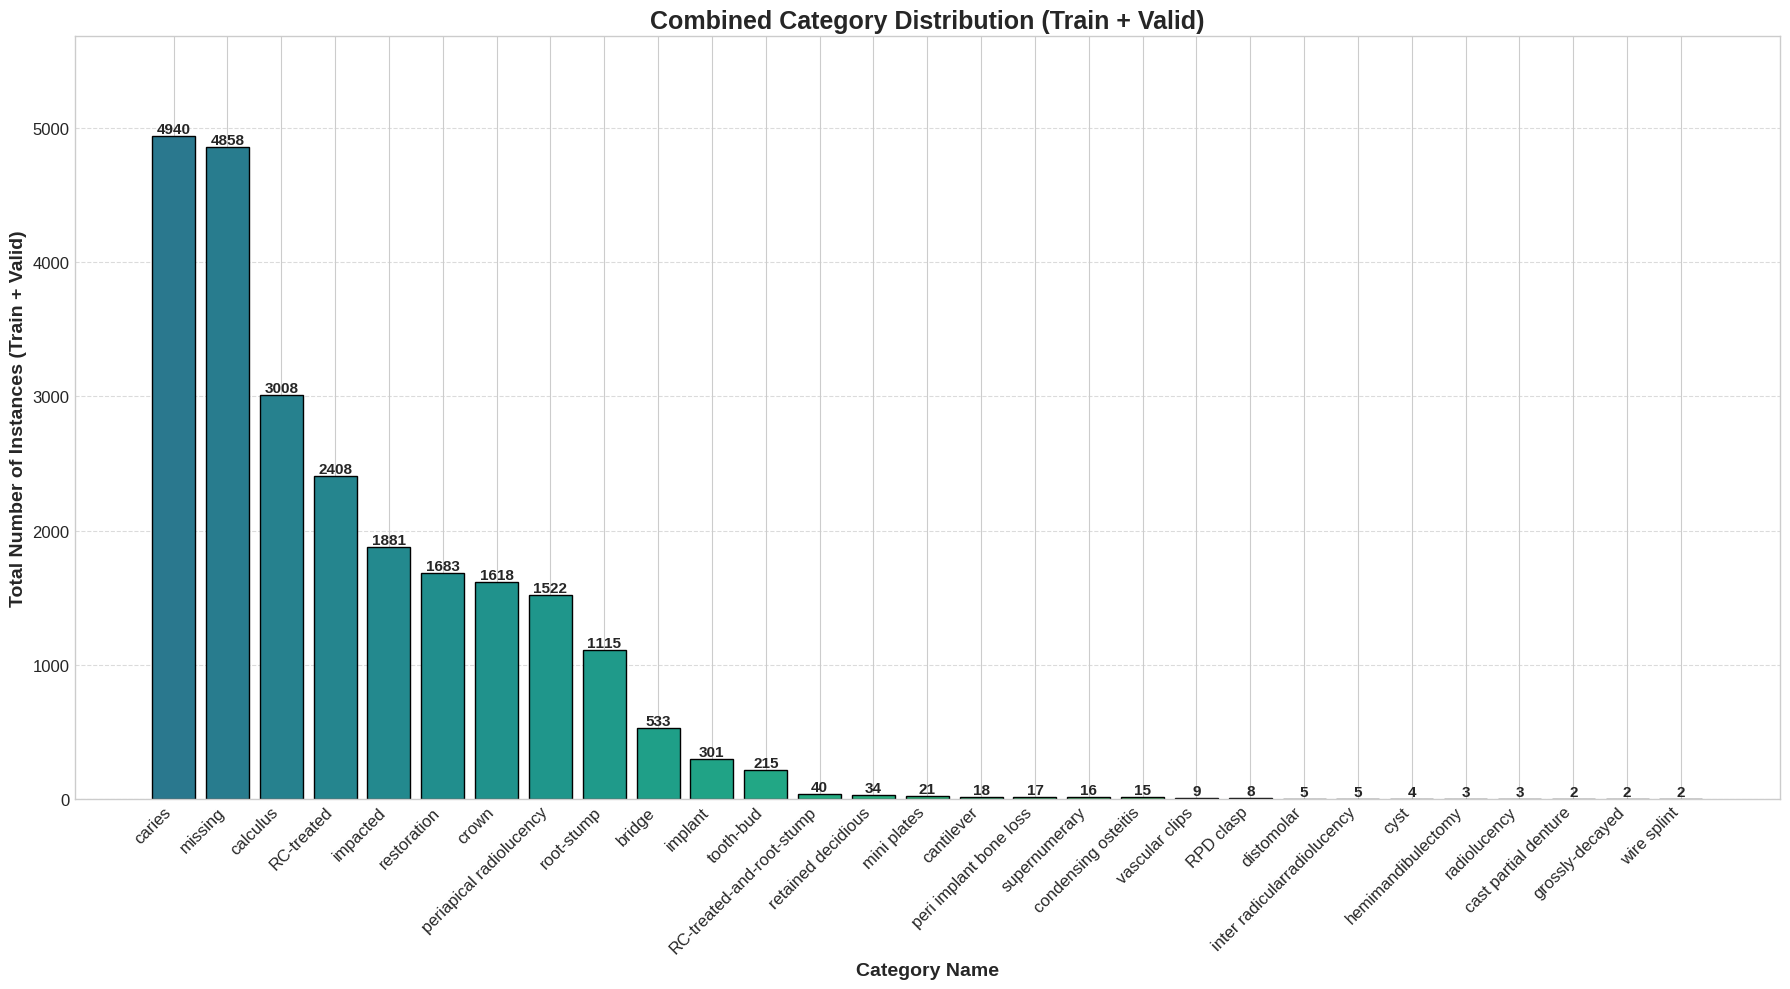

In [ ]:
def get_counts_from_file(json_path):
    """
    Helper function to load a single COCO JSON file and return the
    counts for all annotations.
    """
    if not os.path.exists(json_path):
        print(f"Warning: Annotation file not found at '{json_path}'. Returning zero counts.")
        return defaultdict(int)

    with open(json_path, 'r') as f:
        data = json.load(f)

    annotation_counts = defaultdict(int)
    for ann in data['annotations']:
        annotation_counts[ann['category_id']] += 1
    return annotation_counts

def print_combined_category_counts(base_dir):
    """
    Reads 'train' and 'valid' COCO JSON files, combines their instance counts
    for a predefined list of categories, prints the results in a table, and
    generates a bar chart of the total counts.

    Args:
        base_dir (str): The base directory containing the 'train' and 'valid'
                        folders (e.g., '/content/extracted_opg').
    """
    # 1. Define the list of categories in the desired print order
    target_categories = [
        {"id": 33, "name": "RC-treated"}, {"id": 34, "name": "RC-treated-and-root-stump"},
        {"id": 35, "name": "RPD clasp"}, {"id": 36, "name": "bridge"},
        {"id": 37, "name": "calculus"}, {"id": 38, "name": "cantilever"},
        {"id": 39, "name": "caries"}, {"id": 40, "name": "cast partial denture"},
        {"id": 41, "name": "condensing osteitis"}, {"id": 42, "name": "crown"},
        {"id": 43, "name": "cyst"}, {"id": 44, "name": "distomolar"},
        {"id": 45, "name": "grossly-decayed"}, {"id": 46, "name": "hemimandibulectomy"},
        {"id": 47, "name": "impacted"}, {"id": 48, "name": "implant"},
        {"id": 49, "name": "inter radicularradiolucency"}, {"id": 50, "name": "mini plates"},
        {"id": 51, "name": "missing"}, {"id": 52, "name": "peri implant bone loss"},
        {"id": 53, "name": "periapical radiolucency"}, {"id": 54, "name": "radiolucency"},
        {"id": 55, "name": "restoration"}, {"id": 56, "name": "retained decidious"},
        {"id": 57, "name": "root-stump"}, {"id": 58, "name": "supernumerary"},
        {"id": 59, "name": "tooth-bud"}, {"id": 60, "name": "vascular clips"},
        {"id": 61, "name": "wire splint"},{"id": 62, "name": "joint crowns"}
    ]

    train_path = os.path.join(base_dir, 'train', '_annotations.coco.json')
    valid_path = os.path.join(base_dir, 'valid', '_annotations.coco.json')

    print(f"[INFO] Reading train data from: {train_path}")
    train_counts = get_counts_from_file(train_path)

    print(f"[INFO] Reading validation data from: {valid_path}")
    valid_counts = get_counts_from_file(valid_path)

    print("\n--- Combined Category Counts (Train + Valid) ---")
    print("-" * 65)
    print(f"{'ID':<5} {'Category Name':<30} {'Train':<10} {'Valid':<10} {'Total':<10}")
    print(f"{'-'*4:<5} {'-'*29:<30} {'-'*9:<10} {'-'*9:<10} {'-'*9:<10}")

    category_data = []
    for category in target_categories:
        cat_id = category["id"]
        cat_name = category["name"]

        train_count = train_counts.get(cat_id, 0)
        valid_count = valid_counts.get(cat_id, 0)
        total_count = train_count + valid_count

        print(f"{cat_id:<5} {cat_name:<30} {train_count:<10} {valid_count:<10} {total_count:<10}")
        category_data.append({"name": cat_name, "total": total_count})

    print("-" * 65)

    sorted_category_data = sorted(category_data, key=lambda x: x['total'], reverse=True)
    plot_names = [item['name'] for item in sorted_category_data]
    plot_totals = [item['total'] for item in sorted_category_data]

    print("\n[INFO] Generating combined distribution bar chart...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))

    colors = plt.cm.viridis(np.linspace(0.4, 0.9, len(plot_totals)))
    bars = ax.bar(plot_names, plot_totals, color=colors, edgecolor='black', zorder=2)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height,
                f'{height}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_xlabel("Category Name", fontsize=14, fontweight='bold')
    ax.set_ylabel("Total Number of Instances (Train + Valid)", fontsize=14, fontweight='bold')
    ax.set_title("Combined Category Distribution (Train + Valid)", fontsize=18, fontweight='bold')
    plt.xticks(rotation=45, ha="right", fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
    ax.set_ylim(0, max(plot_totals) * 1.15)

    plt.tight_layout()
    print("[INFO] Displaying chart...")
    plt.show()


if __name__ == '__main__':
    BASE_DATA_DIRECTORY = '/content/extracted_opg'

    print_combined_category_counts(BASE_DATA_DIRECTORY)


- Preserve

caries, missing, calculus, RC-treated, impacted, restoration, crown, periapical radiolucency, root-stump, bridge, implant, tooth-bud, RC-treated-and-root-stump

- May Preserve (with caution)

retained decidious, supernumerary, mini plates, cantilever, condensing osteitis, peri implant bone loss

- Exclude or Merge

vascular clips, distomolar, RPD clasp, cyst, hemimandibulectomy, radiolucency, inter radicularradiolucency, cast partial denture, wire splint, grossly-decayed

# Feature Engineering

In [ ]:
# preserve_classes = [caries, missing, calculus, RC-treated, impacted, restoration, crown, periapical radiolucency, root-stump, bridge, implant, tooth-bud, RC-treated-and-root-stump, retained decidious]